Importing the libs & Getting the Data Set

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
# Importing the dataset
housing_df = pd.read_csv("data\housing.txt")

In [4]:
housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


<AxesSubplot:xlabel='median_house_value', ylabel='Count'>

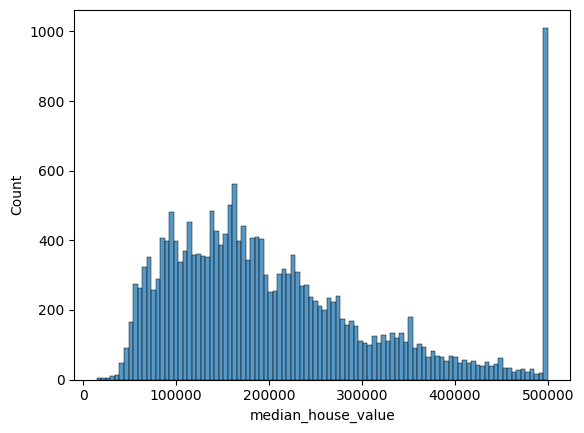

In [14]:
# EDA
sns.histplot(housing_df.median_house_value, bins=100)

# Yes, it has long tail and data is left skewed

In [64]:
# Selecting Features
features = [
    'latitude',
    'longitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

base_df = housing_df.copy()[features]
base_df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


# Solution > Question 1

In [59]:
base_df.isnull().sum()

# Ans: 207

latitude                0
longitude               0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
dtype: int64

# Solution > Question 2

In [58]:
base_df.population.median()

1166.0

In [32]:
# Split the data
np.random.seed(42)
np.random.shuffle(np.arange(len(base_df)))

base_df_size = len(base_df)

n_val = int(base_df_size * 0.2)
n_test = int(base_df_size * 0.2)
n_train = base_df_size - n_val - n_test

median_house_value = base_df.median_house_value
# base_df.drop("median_house_value", axis=1, inplace=True)

median_house_value_log = np.log1p(median_house_value)

In [65]:
def split_data_train_test_val(idx):    
    train = base_df.iloc[idx[:n_train]]
    val = base_df.iloc[idx[n_train:n_train+n_val]]
    test = base_df.iloc[idx[n_train+n_val:]]
    
    train = train.reset_index(drop=True)
    val = val.reset_index(drop=True)
    test = test.reset_index(drop=True)
    
    return train, val, test

df_train, df_val, df_test = split_data_train_test_val(np.arange(base_df_size))

# Taking log of median_house_value in all data sets before droping from main data set
y_train = np.log1p(df_train.median_house_value.values)
y_val = np.log1p(df_val.median_house_value.values)
y_test = np.log1p(df_test.median_house_value.values)

# Droping the median_house_value value from all DFs
base_df.drop("median_house_value", axis=1, inplace=True)
df_train.drop("median_house_value", axis=1, inplace=True)
df_val.drop("median_house_value", axis=1, inplace=True)
df_test.drop("median_house_value", axis=1, inplace=True)


# Solution > Question 3

In [56]:
def replacement_with_zero(df):    
    return df.fillna(0).values

def replacement_with_mean(df):
    df.total_bedrooms.fillna(df.total_bedrooms.mean(), inplace=True)
    return df.values
    
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def rmse(y, y_pred):
    err = y - y_pred
    se = err ** 2
    mse = se.mean()
    return np.sqrt(mse)


In [39]:
# With Zero Value

X_train = replacement_with_zero(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = replacement_with_zero(df_val)
y_pred = w0 + X_val.dot(w)

score = rmse(y_val, y_pred)
round(score, 2)

0.36

In [57]:
# With Mean Value

X_train = replacement_with_mean(df_train)
w0, w = train_linear_regression(X_train, y_train)

X_val = replacement_with_zero(df_val)
y_pred = w0 + X_val.dot(w)

score = rmse(y_val, y_pred)
round(score, 2)

0.36

# Solution > Question 4

In [62]:
regularized_list = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

def lr_regularised_training(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

for r in regularized_list:
    X_train = replacement_with_zero(df_train)
    w0, w = lr_regularised_training(X_train, y_train, r=r)

    X_val = replacement_with_zero(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)

    print(f' regularisation: {r} and score: {round(score, 2)}')

 regularisation: 0, score: 0.36
 regularisation: 1e-06, score: 0.36
 regularisation: 0.0001, score: 0.36
 regularisation: 0.001, score: 0.36
 regularisation: 0.01, score: 0.36
 regularisation: 0.1, score: 0.36
 regularisation: 1, score: 0.37
 regularisation: 5, score: 0.38
 regularisation: 10, score: 0.38


# Solution > Question 5

In [67]:
base_df = housing_df.copy()[features]
base_df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,37.88,-122.23,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,37.86,-122.22,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,37.85,-122.24,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,37.85,-122.25,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,37.85,-122.25,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [77]:
scores = []
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
base_df = housing_df.copy()[features]

def split_data(idx):
    df_train = base_df.iloc[idx[:n_train]]
    df_val = base_df.iloc[idx[n_train:n_train+n_val]]
    df_test = base_df.iloc[idx[n_train+n_val:]]
    
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    
    y_train = np.log1p(df_train.median_house_value.values)
    y_val = np.log1p(df_val.median_house_value.values)
    y_test = np.log1p(df_test.median_house_value.values)
    
    return df_train, df_val, df_test, y_train, y_val, y_test

for seed in seeds:
    np.random.seed(seed)

    np.random.shuffle(np.arange(base_df_size))
    
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(np.arange(base_df_size))
    
    X_train = replacement_with_zero(df_train)
    w0, w = lr_regularised_training(X_train, y_train, r=0.000001)

    X_val = replacement_with_zero(df_val)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_val, y_pred)
    
    scores.append(score)
    
round(np.std(scores),3)

0.0